Get Data

In [1]:
import os
import hashlib
import requests

cache_dir = './data'
def download_data(file, hash) :
    url = "https://p.cloudgav.com/"+file
    fname = os.path.join(cache_dir, url.split('/')[-1])
    print(f'file in {fname}')
    dl = False
    os.makedirs(cache_dir, exist_ok=True)

    if os.path.exists(fname):
        with open(fname, 'r+b') as f:
            content = f.read()
            if len(content ) == 0:
                print('empty file')
                dl = True
            else:
                sha256 = hashlib.sha256()
                sha256.update(content)
                print(f"sha256 is {sha256.hexdigest()}")
                if hash != sha256.hexdigest():
                    f.truncate(0)
                    dl = True
                else:
                    print("file is good, no need to re-download")
    else:
        dl = True

    if dl == True:
        print(f"Download to {fname}")
        with open(fname, 'w+b') as f:
            r = requests.get(url, stream=True, verify=True)
            if r.status_code != 200:
                raise SystemExit(f"status error {r.status_code}!")

            # assuming the download is always correct
            f.write(r.content)
            print("Done")

In [2]:
download_data("kaggle_house_pred_train.csv", "1e18addf81e5e4d347cc17ee6075bbe4a42b7fa26b9e5b063e8f692a5f929d41")
download_data("kaggle_house_pred_test.csv", "8fdd3d829d4d986b58f845c9553b225e67dd8383624d90fb6ca1d4bed5798c1e")

file in ./data/kaggle_house_pred_train.csv
sha256 is 1e18addf81e5e4d347cc17ee6075bbe4a42b7fa26b9e5b063e8f692a5f929d41
file is good, no need to re-download
file in ./data/kaggle_house_pred_test.csv
sha256 is 8fdd3d829d4d986b58f845c9553b225e67dd8383624d90fb6ca1d4bed5798c1e
file is good, no need to re-download


Read data in, then filter out the features which are not useful

In [3]:
import pandas as pd

train_df = pd.read_csv(os.path.join(cache_dir, "kaggle_house_pred_train.csv"))
test_df = pd.read_csv(os.path.join(cache_dir, "kaggle_house_pred_test.csv"))
train_df.shape, test_df.shape

((1460, 81), (1459, 80))

In [4]:
train_cols = sorted(train_df.columns)
test_cols = sorted(test_df.columns)

print(train_df.shape, train_cols)
print(test_df.shape,test_cols)

print("train_df.columns ",train_df.columns)


(1460, 81) ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'Id', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig', 'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold', 'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SalePrice', 'SaleType', 'ScreenPorch

Drop not useful columns
TODO: please also remove multicollinearity, such as "Parking", and "Parking features", or combine them into one, and "State", "City", "Region" can be represented by Zip?

Clean up the data

In [5]:
import random
# TODO: make a a real k fold instead of random selection
def k_data_split(data_len, k):
    if k >= data_len or k < 3:
        raise SystemExit(f"k is too big or too small {k}")
    # print(f"data_len {data_len}")
    k_len = data_len//k
    index = list(range(0,data_len))
    random.shuffle(index)
    return index[0:k_len], index[k_len:]

In [6]:
import numpy as np

train_df.drop('Id', axis=1, inplace=True)
print(f'after drop Id, shape ',train_df.shape)
numeric_features = train_df.dtypes[train_df.dtypes != 'object'].index
train_df[numeric_features] = train_df[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
train_df[numeric_features] = train_df[numeric_features].fillna(0)
print(f'after fillna, shape ', train_df.shape)

train_df = pd.get_dummies(train_df, dummy_na=True,dtype=np.uint8)
# set dtype to unit8 then don't need the line below
# train_df = train_df.astype(float)

pd.set_option('display.max_row', None)
print(f"data type: {train_df.dtypes}")


train_df.to_csv('cleanup_data1.csv',index=False)

train_df.shape

after drop Id, shape  (1460, 80)
after fillna, shape  (1460, 80)
data type: MSSubClass               float64
LotFrontage              float64
LotArea                  float64
OverallQual              float64
OverallCond              float64
YearBuilt                float64
YearRemodAdd             float64
MasVnrArea               float64
BsmtFinSF1               float64
BsmtFinSF2               float64
BsmtUnfSF                float64
TotalBsmtSF              float64
1stFlrSF                 float64
2ndFlrSF                 float64
LowQualFinSF             float64
GrLivArea                float64
BsmtFullBath             float64
BsmtHalfBath             float64
FullBath                 float64
HalfBath                 float64
BedroomAbvGr             float64
KitchenAbvGr             float64
TotRmsAbvGrd             float64
Fireplaces               float64
GarageYrBlt              float64
GarageCars               float64
GarageArea               float64
WoodDeckSF               float64


(1460, 331)

In [7]:
import torch

if torch.cuda.is_available():
    print(f"found {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    
print(f"using device: {device}")

train_data_tensor = torch.tensor(train_df.drop("SalePrice",axis=1).values, dtype=torch.float32).to(device)
train_label_tensor = torch.tensor(train_df["SalePrice"].values, dtype=torch.float32).to(device)
# print(f"train_data_tensor : {train_data_tensor}")

found NVIDIA GeForce RTX 4090
using device: cuda:0


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

split data into k-fold, one for verification and rest for training

In [ ]:
from torch import Tensor, nn
import torch

loss = nn.MSELoss()

class MSLEloss(nn.Module):
    def __init__(self):
        super().__init__()
    # forward will be automatically called when this class is from nn.Module
    def forward(self, predicted, target):
        predicted_mod = torch.clamp(predicted, 1,float('inf'))
        target_mod = torch.clamp(target, 1, float('inf')).reshape((-1,1))
        # r = torch.sqrt(torch.mean((torch.log(predicted_mod) - torch.log(target_mod)) ** 2))
        r = torch.sqrt(loss(torch.log(predicted_mod), torch.log(target_mod)))

        # print(f"log loss {r}, shape {r.shape}, predicted shape {predicted.shape}: {predicted[0:3]}, target shape {target.shape}: {target[0:3]}")
        return r.item()

log_mse_loss = MSLEloss()


def nn_net():
    feature_size = train_data_tensor.shape[1]
    return nn.Sequential(nn.Linear(feature_size,1))
    # return nn.Sequential(nn.Linear(feature_size,feature_size//2),
    #                      nn.ReLU(),
    #                      nn.Linear(feature_size//2, 1)) 
net = nn_net()

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Convert DataFrame to a PyTorch Dataset
class CustomDataset(TensorDataset):
    def __init__(self, data_tensor, label_tensor):
        self.features = data_tensor
        self.labels = label_tensor.reshape((-1,1))

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# K = 10
# epochs = 20
# batch_size = 32
# lr = 1e-3
# weight_decay = 1e-5

K, epochs, lr, weight_decay, batch_size = 5, 20, 5, 0, 64

net = net.to(device)

optimizer = torch.optim.Adam(net.parameters(),
                                 lr = lr,
                                 weight_decay = weight_decay)
train_loss_mean, verify_loss_mean, train_loss_array, verify_loss_array = np.zeros((epochs)), np.zeros((epochs)), \
                                                np.zeros((K,epochs)), np.zeros((K,epochs)) 

train_ls, test_ls = [], []
for i in range(K):
    print(f' ===> K:{i}')
    k_verify_index,k_train_index = k_data_split(len(train_data_tensor), K)
    # print(f"train data len {len(k_train_index)}, verify data len {len(k_verify_index)}")
    # print(f"k_train_index {k_train_index}")

    k_train_data_tensor = train_data_tensor[k_train_index]
    k_train_label_tensor = train_label_tensor[k_train_index]
    k_verify_data_tensor = train_data_tensor[k_verify_index]
    k_verify_label_tensor = train_label_tensor[k_verify_index]

    # print(f"k_train_data_tensor {k_train_data_tensor}")
    # print(f"k_train_label_tensor {k_train_label_tensor}")

    train_data = DataLoader(CustomDataset(k_train_data_tensor,k_train_label_tensor), shuffle=True, batch_size = batch_size)

    j = -1
    for ep in range(epochs):
        # print(f'\t\tepoch:{ep}')
        j += 1
        for X, y in train_data:
            # print(f"X shape, {X.shape} {X.dtype}, y shape {y.shape}")
            optimizer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            optimizer.step()        

        # print(t_t.shape, l_t.shape)
        l1 = log_mse_loss(net(k_train_data_tensor), k_train_label_tensor)
        l2 = log_mse_loss(net(k_verify_data_tensor), k_verify_label_tensor)

        train_ls.append(l1)
        test_ls.append(l2)

        train_loss_array[i][j] += l1
        # print(f'k_verify_data_tensor shape {k_verify_data_tensor.shape}, k_verify_label_tensor shape {k_verify_label_tensor.shape}')
        verify_loss_array[i][j] += l2
        # print(l1, l2)

    if i == 0:
        print(f"train_ls: {train_ls}")
        print(f"test_ls: {test_ls}")
        d2l.plot(list(range(1, epochs + 1)), [train_ls, test_ls],
                    xlabel='epoch', ylabel='rmse', xlim=[1, epochs],
                    legend=['train', 'valid'], yscale='log')
# index is epochs#
train_loss_mean = train_loss_array.sum(axis=0) / train_loss_array.shape[0]
verify_loss_mean = verify_loss_array.sum(axis=0) / verify_loss_array.shape[0]
train_loss_array.shape, verify_loss_array.shape,  train_loss_mean, verify_loss_mean

 ===> K:0
2.0947937965393066 2.1957051753997803
1.9217058420181274 1.8744267225265503
0.7763042449951172 0.8848796486854553
1.8078926801681519 1.8730238676071167
1.060874104499817 0.8562899231910706
1.7416388988494873 1.754103660583496
0.8584276437759399 0.8667383790016174
1.042184829711914 1.1002720594406128
1.3236019611358643 1.301988959312439
1.6209567785263062 1.6263233423233032
1.289175271987915 1.28769052028656
0.8371454477310181 0.9153153896331787
1.6162817478179932 1.635650396347046
0.6302686333656311 0.6894010901451111
2.1080291271209717 2.135721206665039
1.32001793384552 1.2707328796386719
1.1834492683410645 1.2529653310775757
2.3055152893066406 2.2788281440734863
1.4127941131591797 1.5028107166290283
2.038663625717163 2.00431227684021
 ===> K:1
1.1330169439315796 1.1553236246109009
0.7142514586448669 0.6473894715309143
3.124497890472412 3.17626690864563
1.3313159942626953 1.4367722272872925
1.9050575494766235 1.869179129600525
1.9638310670852661 1.8832988739013672
2.64552474

((5, 20),
 (5, 20),
 array([1.51757407, 1.47937623, 1.69680854, 1.28858236, 1.3397788 ,
        1.455398  , 1.15805986, 1.10714096, 1.60043073, 1.69143496,
        1.7813923 , 1.64152122, 1.66247872, 1.55620402, 2.40599533,
        1.57942867, 1.68837066, 1.6950471 , 1.60050136, 1.57330223]),
 array([1.58082243, 1.46794204, 1.72121563, 1.36734445, 1.34418188,
        1.47907277, 1.214059  , 1.08171494, 1.53595262, 1.67306132,
        1.80670695, 1.67154146, 1.68049536, 1.56054478, 2.38149494,
        1.58681087, 1.695354  , 1.71006986, 1.68997731, 1.56987146]))

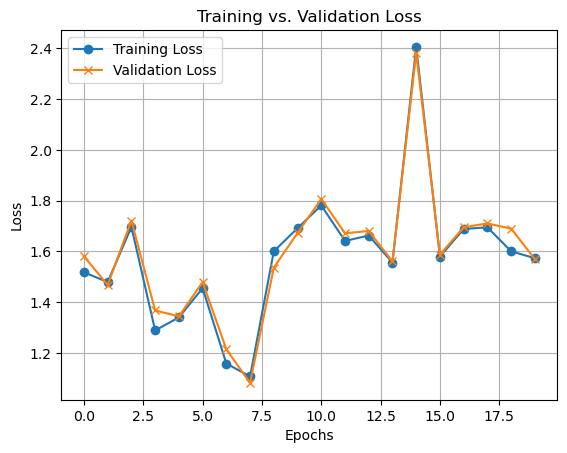

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.plot(np.arange(epochs), train_loss_mean, marker='o', label='Training Loss')
plt.plot(np.arange(epochs), verify_loss_mean, marker='x', label='Validation Loss')

# Adding title and labels
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale='log'
plt.legend()  # This adds a legend to distinguish between the two lines
plt.grid(True)
plt.show()

In [ ]:
print(device)
print(net)

cuda:0
Sequential(
  (0): Linear(in_features=330, out_features=1, bias=True)
)
